# P2HGAN
Generating Handwritten text images from Printed text images using CycleGAN



In [4]:
# example of defining composite models for training cyclegan generators
from keras.optimizers import Adam
from keras.models import Model
from keras.models import Sequential
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import Activation
from keras.layers import LeakyReLU
from keras.initializers import RandomNormal
from keras.layers import Concatenate
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import os
from PIL import Image
from matplotlib import image
import numpy as np
from numpy import ones
from numpy import zeros

# define the discriminator model
def define_discriminator(image_shape):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # source image input
    in_image = Input(shape=image_shape)
    nfilters = 32
    kernel_size = 4
    # C64
    d = Conv2D(nfilters, kernel_size, strides=(2,2), padding='same', kernel_initializer=init)(in_image)
    d = LeakyReLU(alpha=0.2)(d)
    # C128
    d = Conv2D(nfilters*2, kernel_size, strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C256
    d = Conv2D(nfilters*4, kernel_size, strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C512
    d = Conv2D(nfilters*8, kernel_size, strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # second last output layer
    d = Conv2D(nfilters*8, kernel_size, padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # patch output
    patch_out = Conv2D(1, kernel_size, padding='same', kernel_initializer=init)(d)
    # define model
    model = Model(in_image, patch_out)
    # compile model
    model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
    return model

# generator a resnet block
def resnet_block(n_filters, input_layer):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # first layer convolutional layer
    g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # second convolutional layer
    g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    # concatenate merge channel-wise with input layer
    g = Concatenate()([g, input_layer])
    return g

# define the standalone generator model
def define_generator(image_shape, n_resnet=9):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=image_shape)
    n_filters = 32
    kernel_size = 3
    # c7s1-64
    g = Conv2D(n_filters, (7,7), padding='same', kernel_initializer=init)(in_image)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # d128
    g = Conv2D(n_filters*2, kernel_size, strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # d256
    g = Conv2D(n_filters*4, kernel_size, strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # R256
    for _ in range(n_resnet):
        g = resnet_block(n_filters*4, g)
    # u128
    g = Conv2DTranspose(n_filters*2, kernel_size, strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # u64
    g = Conv2DTranspose(n_filters, kernel_size, strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # c7s1-3
    g = Conv2D(1, (7,7), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    out_image = Activation('tanh')(g)
    # define model
    model = Model(in_image, out_image)
    return model

# define a composite model for updating generators by adversarial and cycle loss
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
    # ensure the model we're updating is trainable
    g_model_1.trainable = True
    # mark discriminator as not trainable
    d_model.trainable = False
    # mark other generator model as not trainable
    g_model_2.trainable = False
    # discriminator element
    input_gen = Input(shape=image_shape)
    gen1_out = g_model_1(input_gen)
    output_d = d_model(gen1_out)
    # identity element
    input_id = Input(shape=image_shape)
    output_id = g_model_1(input_id)
    # forward cycle
    output_f = g_model_2(gen1_out)
    # backward cycle
    gen2_out = g_model_2(input_id)
    output_b = g_model_1(gen2_out)
    # define model graph
    model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
    # define optimization algorithm configuration
    #learning_rate = 0.0002
    #decay_rate = 0.0002 / 100
    #momentum = 0.8
    #opt = Adam(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
    opt = Adam(lr=0.0002, beta_1=0.5)
        
    # compile model with weighting of least squares loss and L1 loss
    model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
    return model

Using TensorFlow backend.


In [5]:
from random import randint
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape, patch_shape2):
    # choose random instances
    #print(dataset.shape[0])
    #print(n_samples)
    ix = randint(0, dataset.shape[0]-1)
    #print(ix)
    # retrieve selected images
    X = dataset[ix:ix+n_samples]
    #print(X.shape)
    # generate 'real' class labels (1)
    y = ones((n_samples, patch_shape, patch_shape2, 1))
    #print(y.shape)
    return X, y
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, dataset, patch_shape, patch_shape2):
	# generate fake instance
	X = g_model.predict(dataset)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape2, 1))
    #print(y.shape)
	return X, y

# select a batch of real samples
#X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
#X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
# generate a batch of fake samples
#X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
#X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
# update image pool for fake images

In [6]:
import random
from random import random
def update_image_pool(pool, images, max_size=50):
	selected = list()
	for image in images:
		if len(pool) < max_size:
			# stock the pool
			pool.append(image)
			selected.append(image)
		elif random() < 0.5:
			# use image, but don't add it to the pool
			selected.append(image)
		else:
			# replace an existing image and use replaced image
			#print(len(pool))
			ix = randint(0, len(pool)-1)
			selected.append(pool[ix])
			pool[ix] = image
	return np.asarray(selected)

In [7]:
def sample_images(trainA,trainB,model_BtoA,model_AtoB,n_patch,n_patch2,epoch):
        c = 3
        #print(trainA.shape)
        imgs_A, _ = generate_real_samples(trainA, 1, n_patch, n_patch2)
        imgs_B, _ = generate_real_samples(trainB, 1, n_patch, n_patch2)
        #print(imgs_A.shape)
        # Translate images to the other domain
        fake_B, _ = generate_fake_samples(model_AtoB, imgs_A, n_patch, n_patch2)
        fake_A, _ = generate_fake_samples(model_BtoA, imgs_B, n_patch, n_patch2)
        # Translate back to original domain
        reconstr_A, _ = generate_fake_samples(model_BtoA, fake_B, n_patch, n_patch2)
        reconstr_B, _ = generate_fake_samples(model_AtoB, fake_A, n_patch, n_patch2)

        gen_imgs = np.concatenate([imgs_A, fake_B, reconstr_A, imgs_B, fake_A, reconstr_B])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Original', 'Translated', 'Reconstructed']
        fig1, axs1 = plt.subplots(c)

        cnt = 0
        for j in range(c):
            axs1[j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs1[j].set_title(titles[j])
            axs1[j].axis('off')
            cnt += 1
        fig1.savefig("images_cycle/AtoB/%d.png" % epoch)
        plt.close()

        fig2, axs2 = plt.subplots(c)
        cnt = 3
        for i in range(c):
            axs2[i].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs2[i].set_title(titles[i])
            axs2[i].axis('off')
            cnt += 1
        fig2.savefig("images_cycle/BtoA/%d.png" % epoch)
        plt.close()


# Training

We train the model on each pair of printed-handwritten images for 100 epochs. 

In [8]:
# train cyclegan models
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset):
    # define properties of the training run
    n_epochs, n_batch, = 100, 1
    # determine the output square shape of the discriminator
    #print(d_model_A.output_shape)
    n_patch = d_model_A.output_shape[1]
    n_patch2 = d_model_A.output_shape[2]
    # unpack dataset
    trainA, trainB = dataset
    #print(trainA.shape)
    #print(trainB.shape)
    # prepare image pool for fakes
    poolA, poolB = list(), list()
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # manually enumerate epochs
    for i in range(n_steps):
        # select a batch of real samples
        X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch, n_patch2)
        X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch, n_patch2)
        # generate a batch of fake samples
        X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch, n_patch2)
        X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch, n_patch2)
        # update fakes from pool
        X_fakeA = update_image_pool(poolA, X_fakeA)
        X_fakeB = update_image_pool(poolB, X_fakeB)
        # update generator B->A via adversarial and cycle loss
        g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
        # update discriminator for A -> [real/fake]
        dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
        dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
        # update generator A->B via adversarial and cycle loss
        g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
        # update discriminator for B -> [real/fake]
        dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
        dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
        # summarize performance
        print('>%d/%d, dA[loss1:%.3f,loss2:%.3f] dB[loss1:%.3f,loss2:%.3f] g[loss1:%.3f,loss2:%.3f]' % (i+1,n_steps, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
        # If at save interval => save generated image samples
        if i % 100 == 0:
          sample_images(trainA,trainB,g_model_BtoA,g_model_AtoB,n_patch,n_patch2,(i/100))
          d_model_A.save('saved_model/p2hDiscA_2_%d.h5' % (i/100))
          d_model_B.save('saved_model/p2hDiscB_2_%d.h5' % (i/100))
          g_model_AtoB.save('saved_model/p2hGenAB_2_%d.h5' % (i/100))
          g_model_BtoA.save('saved_model/p2hGenBA_2_%d.h5' % (i/100))
          print('model saved')

In [16]:
import cv2
def load_imgs():
    # load Printed dataset
    printed_dir = 'datasets/sentences/trainA'
    printed_imgs = list()
    for f in os.listdir(printed_dir):
      #load the image
      img = image.imread(printed_dir + '/' + f,'r')
      #img = cv2.imread(printed_dir + '/' + f, cv2.IMREAD_GRAYSCALE)
      #Resize to same as hw_imgs
      #dim = (128,32)
      #img = cv2.resize(img, dim, interpolation = cv2.INTER_LINEAR)
      printed_imgs.append(img)
    # load HW dataset
    hw_dir = 'datasets/sentences/trainB'
    hw_imgs = list()
    for f in os.listdir(hw_dir):
      #load the image
      img = image.imread(hw_dir + '/' + f,'r')
      #img = cv2.imread(hw_dir + '/' + f, cv2.IMREAD_GRAYSCALE)
      #Resize to same as hw_imgs
      #dim = (128,32)
      #img = cv2.resize(img, dim, interpolation = cv2.INTER_LINEAR)
      hw_imgs.append(img)
    # load printed test dataset
    printed2_dir = 'datasets/sentences/testA'
    printed2_imgs = list()
    for f in os.listdir(printed2_dir):
      #load the image
      img = image.imread(printed2_dir + '/' + f,'r')
      printed2_imgs.append(img)
    # load HW test dataset
    hw_dir2 = 'datasets/sentences/testB'
    hw_imgs2 = list()
    for f in os.listdir(hw_dir2):
      #load the image
      img2 = image.imread(hw_dir2 + '/' + f,'r')
      hw_imgs2.append(img2)
    printed_imgs = np.asarray(printed_imgs).astype('float32') / 255
    hw_imgs = np.asarray(hw_imgs).astype('float32') / 255
    hw_imgs2 = np.asarray(hw_imgs2).astype('float32') / 255
    printed2_imgs = np.asarray(printed2_imgs).astype('float32') / 255
    printed_imgs = printed_imgs.reshape(printed_imgs.shape[0],
                                      printed_imgs.shape[1],
                                      printed_imgs.shape[2],
                                      1)
    hw_imgs = hw_imgs.reshape(hw_imgs.shape[0],
                                      hw_imgs.shape[1],
                                      hw_imgs.shape[2],
                                      1)
    printed2_imgs = printed2_imgs.reshape(printed2_imgs.shape[0],
                                      printed2_imgs.shape[1],
                                      printed2_imgs.shape[2],
                                      1)
    hw_imgs2 = hw_imgs2.reshape(hw_imgs2.shape[0],
                                      hw_imgs2.shape[1],
                                      hw_imgs2.shape[2],
                                      1)

    return printed_imgs, hw_imgs, printed2_imgs, hw_imgs2

(614, 48, 512, 1)
(578, 48, 512, 1)
(60, 48, 512, 1)


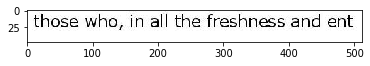

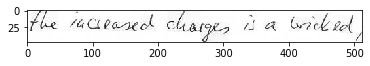

In [17]:
# load a dataset as a list of two numpy arrays
%matplotlib inline
trainA, trainB,testA, testB = load_imgs()
print(trainA.shape)
print(trainB.shape)
print(testB.shape)
dataset = (trainA, trainB)
# check some images
plt.imshow(trainA[0, :, :, 0],cmap='gray')
plt.show()
plt.imshow(trainB[0, :, :, 0],cmap='gray')
plt.show()

In [18]:
%%time
# load a dataset as a list of two numpy arrays
trainA, trainB,testA, testB = load_imgs()
print(trainA.shape)
print(trainB.shape)
print(testB.shape)
dataset = (trainA, trainB)

# input shape
image_shape = (trainA.shape[1],trainA.shape[2],1)
# generator: A -> B
g_model_AtoB = define_generator(image_shape)
# generator: B -> A
g_model_BtoA = define_generator(image_shape)
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)
g_model_AtoB.summary()
g_model_BtoA.summary()
d_model_A.summary()
d_model_B.summary()
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

W1207 03:56:05.676830 16648 deprecation_wrapper.py:119] From C:\Users\Ellysah\Anaconda3\envs\keras-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1207 03:56:05.691791 16648 deprecation_wrapper.py:119] From C:\Users\Ellysah\Anaconda3\envs\keras-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1207 03:56:05.695781 16648 deprecation_wrapper.py:119] From C:\Users\Ellysah\Anaconda3\envs\keras-gpu\lib\site-packages\keras\backend\tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.



(614, 48, 512, 1)
(578, 48, 512, 1)
(60, 48, 512, 1)


W1207 03:56:07.827080 16648 deprecation_wrapper.py:119] From C:\Users\Ellysah\Anaconda3\envs\keras-gpu\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 48, 512, 1)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 48, 512, 32)  1600        input_1[0][0]                    
__________________________________________________________________________________________________
instance_normalization_1 (Insta (None, 48, 512, 32)  64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 48, 512, 32)  0           instance_normalization_1[0][0]   
__________________________________________________________________________________________________
conv2d_2 (

Wall time: 8.11 s


In [ ]:
# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset)

# Results

From the results below, it is evident that the printed text images were indeed converted to handwritten text images. The in
However, the results could be further improved by increasing the layer sizes and depth of the model. But due to limitations in the machine resources, we were only able to train the model using smaller layer size and kernel size. 

(640, 288, 432, 4)
640


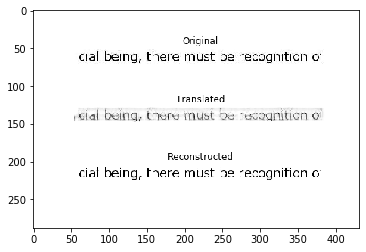

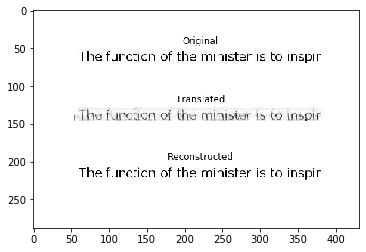

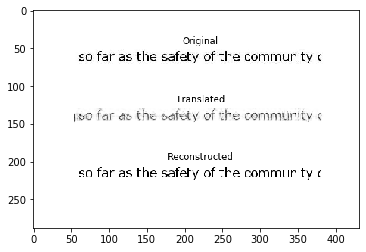

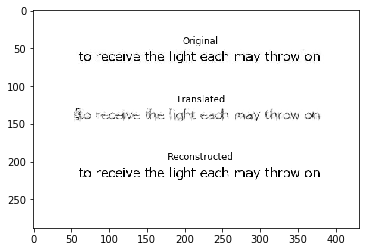

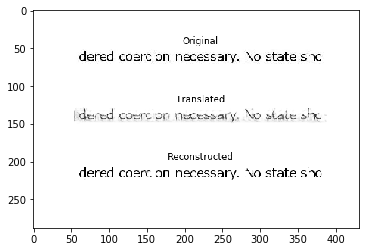

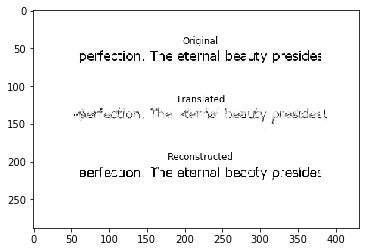

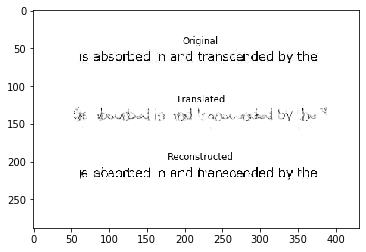

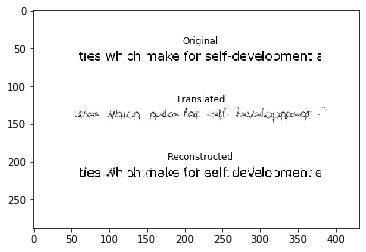

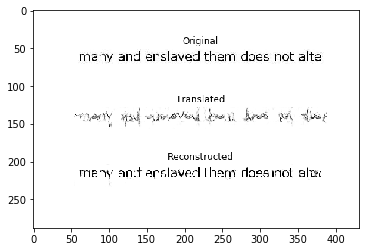

In [30]:
%matplotlib inline
# load Results
AB_dir = 'D:\EE298\cyclegan2\AtoB'
AB_imgs = list()
for f in os.listdir(AB_dir):
  #load the image
  img = image.imread(AB_dir + '/' + f,'r')
  #img = cv2.imread(printed_dir + '/' + f, cv2.IMREAD_GRAYSCALE)
  #Resize to same as hw_imgs
  #dim = (128,32)
  #img = cv2.resize(img, dim, interpolation = cv2.INTER_LINEAR)
  AB_imgs.append(img)
AB_imgs = np.asarray(AB_imgs).astype('float32') / 255
print(AB_imgs.shape)
imlen = AB_imgs.shape[0]
print(imlen)
for i in range(0,imlen): 
    # print last few images
    if i>imlen-10:
        plt.imshow(AB_imgs[i, :, :, 0],cmap='gray')
        plt.show()

In [ ]:
import tensorflow as tf
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.models import load_model
model = load_model('saved_model/p2hGenAB_2_150.h5',custom_objects={'InstanceNormalization':InstanceNormalization})

In [ ]:
from text import str_to_image
response = input("Please enter a sentence: ")
im = str_to_image(response)

In [ ]:
import cv2
import tensorflow as tf
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.models import load_model
model = load_model('saved_model/p2hGenAB_2_357.h5',custom_objects={'InstanceNormalization':InstanceNormalization})
#model.saveAtoB(im, 'test_arch1.png')
X = model.predict(im)
#X = np.asarray(X).astype('float32') / 255
print(X.shape)
# This part only for show the image on the screen, you can delete it if you want
#pathA = 'test_arch1.png'
#img = cv2.imread(pathA)
#cv2.imshow('image', img)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

In [ ]:
#X = np.asarray(X).astype('float32') / 255
cv2.imshow('image',X[0])
cv2.waitKey(0)
cv2.destroyAllWindows()